Import dependencies

In [1]:
from model.layers import GraphSpectralFilterLayer, AnalysisFilter
from model.spectral_filter import Graph
import torch
import torch.nn.functional as F
from torch import nn
from random import seed as rseed
from numpy.random import seed as nseed
from citation import get_planetoid_dataset, random_planetoid_splits, run
from citation.train_eval import evaluate
import numpy as np


Define hyperparameters

In [2]:
dataset_name = 'Cora'

random_splits = False
runs = 1
epochs =400
alpha = 0.4325176513738335
seed =729
lr =0.0001502755734819816
weight_decay =9.70164175612743e-05
patience=100
hidden=83
heads =19
dropout=0.6760251172015357
normalize_features =True
pre_training = False
cuda = False
chebyshev_order =17
edge_dropout =0
node_feature_dropout =0
filter_name ='analysis'

rseed(seed)
nseed(seed)
torch.manual_seed(seed)

cuda = cuda and torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
def get_correctly_predicted_node_idx(net, key):
    net.eval()
    with torch.no_grad():
        logits  = net(dataset[0])[0]
    mask = dataset[0]['{}_mask'.format(key)]
    pred = logits[mask].max(1)[1]
    return { *pred.eq(dataset[0].y[mask]).nonzero().view(-1).tolist() }

In [3]:
def matching_labels_distribution(nodes_set):
    hop_1_matching_percent = []
    hop_2_matching_percent = []
    hop_3_matching_percent = []
    for n in nodes_set:
        hop_1_neighbours = list(nx.ego_graph(G, n.item(), 1).nodes())
        hop_2_neighbours = list(nx.ego_graph(G, n.item(), 2).nodes())
        hop_3_neighbours = list(nx.ego_graph(G, n.item(), 3).nodes())
        node_label = dataset[0].y[n]
        hop_1_labels = dataset[0].y[hop_1_neighbours]
        hop_2_labels = dataset[0].y[hop_2_neighbours]
        hop_3_labels = dataset[0].y[hop_3_neighbours]
        matching_1_labels = node_label == hop_1_labels
        matching_2_labels = node_label == hop_2_labels
        matching_3_labels = node_label == hop_3_labels
        hop_1_matching_percent.append(matching_1_labels.float().sum()/matching_1_labels.shape[0])
        hop_2_matching_percent.append(matching_2_labels.float().sum()/matching_2_labels.shape[0])
        hop_3_matching_percent.append(matching_3_labels.float().sum()/matching_3_labels.shape[0])


    print('matching labels in 1st hop:', torch.tensor(hop_1_matching_percent).mean())
    print('matching labels in 2st hop:', torch.tensor(hop_2_matching_percent).mean())
    print('matching labels in 3rd hop:', torch.tensor(hop_3_matching_percent).mean())
    plt.figure(figsize=(15,3))
    plt.subplot(1, 3, 1)
    plt.hist(hop_1_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 2)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)
    plt.subplot(1, 3, 3)
    plt.hist(hop_2_matching_percent, color = 'blue', edgecolor = 'black', bins = 10)


Define model

In [4]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)
        # self.mlp = nn.Sequential(nn.Linear(hidden * heads, 128),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(128, 64),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(64, 32),
        #                             nn.ReLU(inplace=True),
        #                             nn.Linear(32, dataset.num_classes),
        #                             nn.ReLU(inplace=True))

        # self.W = torch.zeros(hidden * heads, dataset.num_classes)

        self.synthesis = GraphSpectralFilterLayer(self.G, hidden * heads, dataset.num_classes, filter=filter_name,
                                                  device='cuda' if cuda else 'cpu', dropout=dropout,
                                                  out_channels=1, alpha=alpha, pre_training=False,
                                                  chebyshev_order=chebyshev_order)

    def reset_parameters(self):
        self.analysis.reset_parameters()
        # torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)
        # for layer in self.mlp:
        #     if hasattr(layer, 'reset_parameters'):
        #         layer.reset_parameters()
        self.synthesis.reset_parameters()

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_2 = self.synthesis(x)
        x = F.elu(x)
        # x = F.elu(x.mm(self.W))
        # x = self.mlp(x)
        return F.log_softmax(x, dim=1), attentions_1, attentions_2


dataset = get_planetoid_dataset(dataset_name, normalize_features, edge_dropout=edge_dropout,
                                node_feature_dropout=node_feature_dropout)
if cuda:
    dataset[0].to('cuda')

# permute_masks = random_planetoid_splits if random_splits else None
# run(dataset, Net(dataset), runs, epochs, lr, weight_decay,
#     early_stopping, permute_masks)

In [5]:
class SingleNet(torch.nn.Module):
    def __init__(self, dataset):
        super(SingleNet, self).__init__()
        data = dataset[0]
        adj = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.num_edges))
        self.G = Graph(adj)
        self.G.estimate_lmax()

        self.analysis = GraphSpectralFilterLayer(self.G, dataset.num_node_features, hidden,
                                                 dropout=dropout, out_channels=heads, filter=filter_name,
                                                 pre_training=pre_training, device='cuda' if cuda else 'cpu',
                                                 alpha=alpha, chebyshev_order=chebyshev_order)

        self.W = torch.nn.Parameter(torch.zeros(hidden * heads, dataset.num_classes))

    def reset_parameters(self):
        self.analysis.reset_parameters()
        torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)

    def forward(self, data):
        x = data.x
        x = F.dropout(x, p=dropout, training=self.training)
        x, attentions_1 = self.analysis(x)
        x = F.dropout(x, p=dropout, training=self.training)
        x = F.elu(x.mm(self.W))
        return F.log_softmax(x, dim=1), attentions_1, None

Load trained model and evaluate

In [7]:
# model = Net(dataset)
# model.load_state_dict(torch.load('./model/best_{}_gpu.pkl'.format(dataset_name),  map_location={'cuda:0': 'cpu'}))

model = SingleNet(dataset)
model.load_state_dict(torch.load('./model/best_{}_single_layer.pkl'.format(dataset_name)))

filter_kernel = model.analysis.filter_kernel

model_correct_indices = get_correctly_predicted_node_idx(model, 'test')
evaluate(model, dataset[0])

{'train_loss': 0.2787048816680908,
 'train_acc': 0.9337748344370861,
 'val_loss': 0.46922436356544495,
 'val_acc': 0.864,
 'test_loss': 0.4648117125034332,
 'test_acc': 0.863,
 'f1_score': 0.8947562776957164}

Obtain attention weights in layer 1 and 2

In [8]:
with torch.no_grad():
    _, att1, att2 = model(dataset[0])


Build NetworkX Graph

In [9]:
import networkx as nx
from scipy.sparse import coo_matrix
import numpy as np

# Build graph
adj = coo_matrix(
    (np.ones(dataset[0].num_edges),
    (dataset[0].edge_index[0].numpy(), dataset[0].edge_index[1].numpy())),
    shape=(dataset[0].num_nodes, dataset[0].num_nodes))
G = nx.Graph(adj)


In [10]:
from matplotlib import pyplot as plt
def plot_filter_banks(idx=list(range(heads)), kernel=model.analysis.filter._kernel, ax=None):
    x = torch.linspace(0, 2, 100)
    if not ax:
        plt.figure()
        plt.plot(x, kernel(x).detach()[:, idx])
        plt.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])
        plt.show()
    else:
        ax.plot(x, kernel(x).detach()[:, idx])
        ax.legend(['filter {}'.format(i) for i in range(1, len(idx) + 1)])

Plot filterbanks in layer 1 and 2

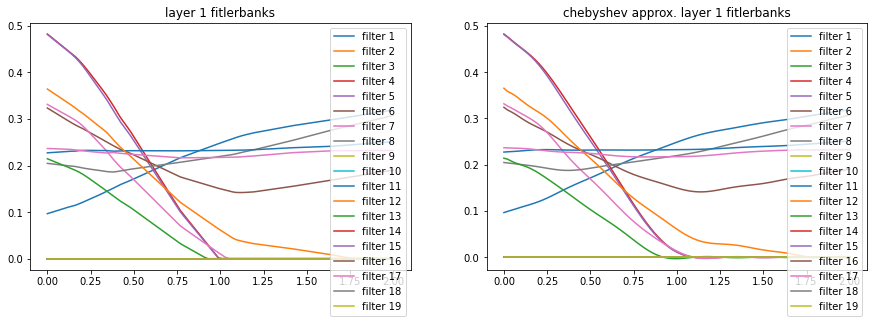

In [11]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 2, 1)
ax1.set_title('layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter._kernel, ax=ax1)
ax2 = plt.subplot(2, 2, 2)
ax2.set_title('chebyshev approx. layer 1 fitlerbanks')
plot_filter_banks(kernel=model.analysis.filter.cheby_eval, ax=ax2)

if hasattr(model, 'synthesis'):
    ax3 = plt.subplot(2, 2, 3)
    ax3.set_title('layer 2 fitlerbank')
    plot_filter_banks(idx=[0], kernel=model.synthesis.filter._kernel, ax=ax3)
    ax4 = plt.subplot(2, 2, 4)
    ax4.set_title('chebyshev approx. layer 2 fitlerbank')
    plot_filter_banks(idx=[0], kernel=model.synthesis.filter.cheby_eval, ax=ax4)

### Frequency cutoff analysis

In [12]:
# Cut frequency bands abruptly
class CutOff(nn.Module):
    def __init__(self, kernel, min_val = 0, max_val = 2):
        super(CutOff, self).__init__()
        self.min = min_val
        self.max = max_val
        self.kernel = kernel

    def reset_parameters(self):
        pass

    def forward(self, x):
        h = torch.where(x.view(-1,1).repeat(1, heads) < self.min, torch.zeros(x.shape[0], heads), self.kernel(x))
        h = torch.where(x.view(-1,1).repeat(1, heads) > self.max, torch.zeros(x.shape[0], heads), h)
        return h

Evaluate low pass cutoff

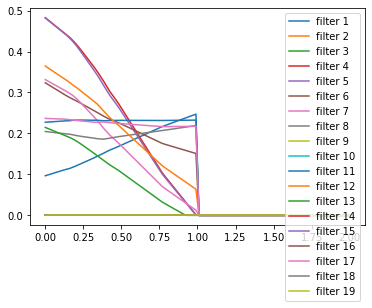

{'train_loss': 0.2944606840610504, 'train_acc': 0.9271523178807947, 'val_loss': 0.4686824381351471, 'val_acc': 0.856, 'test_loss': 0.4725411534309387, 'test_acc': 0.862, 'f1_score': 0.8899556868537666}


In [13]:
threshold = 1
model.analysis.filter_kernel = CutOff(max_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(max_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

low_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')
with torch.no_grad():
    _, low_att1, low_att2 = model(dataset[0])

Evaluate high pass cutoff

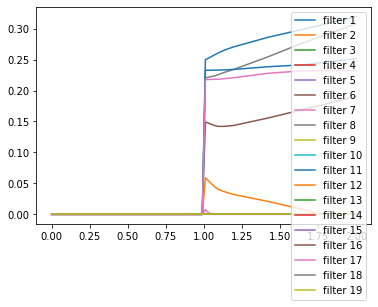

{'train_loss': 0.4018191397190094, 'train_acc': 0.8899006622516556, 'val_loss': 0.5301293134689331, 'val_acc': 0.846, 'test_loss': 0.5281185507774353, 'test_acc': 0.844, 'f1_score': 0.864844903988183}


In [14]:
threshold = 1
model.analysis.filter_kernel = CutOff(min_val=threshold, kernel=filter_kernel)
model.analysis.filter._kernel = CutOff(min_val=threshold, kernel=filter_kernel)
plot_filter_banks(kernel=model.analysis.filter_kernel)
print(evaluate(model, dataset[0]))

high_pass_correct_indices = get_correctly_predicted_node_idx(model, 'test')

with torch.no_grad():
    _, high_att1, high_att2 = model(dataset[0])

Evaluate band pass cutoff

In [47]:
# for threshold in torch.arange(0, 2, 1):
#     model.analysis.filter_kernel = CutOff(min_val=threshold, max_val=threshold+0.1, kernel=model.analysis.filter_kernel)
#     model.analysis.filter._kernel = CutOff(min_val=threshold,max_val=threshold+0.1, kernel=model.analysis.filter_kernel)
# #     plot_filter_banks(kernel=model.analysis.filter_kernel)
#     print(evaluate(model, dataset[0]))

#### Frequency analysis on cutoff

In [15]:
low_not_high_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(low_pass_correct_indices.difference(high_pass_correct_indices))]
high_not_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.difference(low_pass_correct_indices))]
high_and_low_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(high_pass_correct_indices.intersection(low_pass_correct_indices))]


print('Number of node classified correctly by low-pass filters but not by high-pass filters:', len(low_not_high_correct_nodes))
print('Number of node classified correctly by high-pass filters but not by low-pass filters:', len(high_not_low_correct_nodes))
print('Number of node classified correctly by both high-pass and low-pass filters:', len(high_and_low_correct_nodes))

Number of node classified correctly by low-pass filters but not by high-pass filters: 34
Number of node classified correctly by high-pass filters but not by low-pass filters: 16
Number of node classified correctly by both high-pass and low-pass filters: 828


Neighbour distribution of nodes classified correct by high-pass but not low pass

matching labels in 1st hop: tensor(0.6644)
matching labels in 2st hop: tensor(0.6193)
matching labels in 3rd hop: tensor(0.6117)


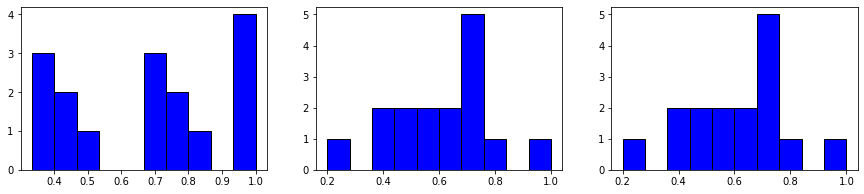

In [19]:
matching_labels_distribution(high_not_low_correct_nodes)

matching labels in 1st hop: tensor(0.6800)
matching labels in 2st hop: tensor(0.3606)
matching labels in 3rd hop: tensor(0.3029)


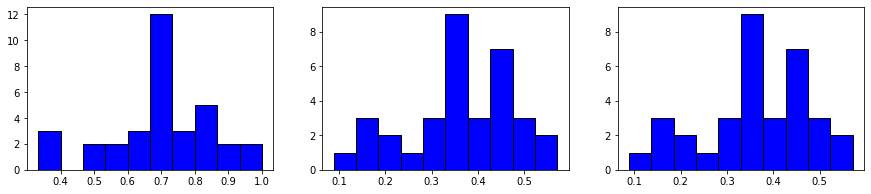

In [18]:
matching_labels_distribution(low_not_high_correct_nodes)

matching labels in 1st hop: tensor(0.9155)
matching labels in 2st hop: tensor(0.8726)
matching labels in 3rd hop: tensor(0.8302)


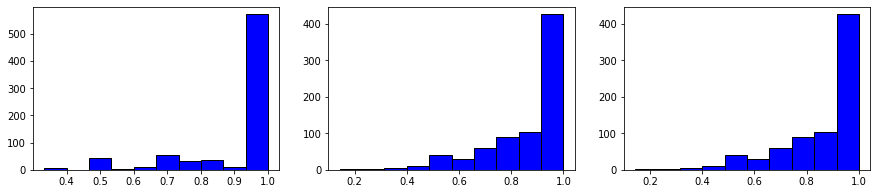

In [51]:
matching_labels_distribution(high_and_low_correct_nodes)

Draw attentions from high-pass filterbank(s)

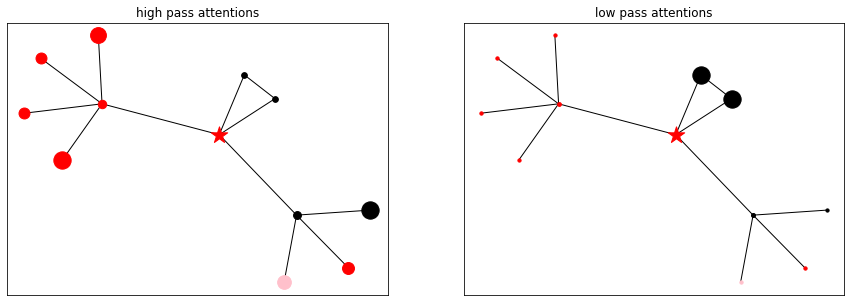

In [23]:
low_attentions = torch.stack(low_att1, 0).sum(0)
high_attentions = torch.stack(high_att1, 0).sum(0)

index = 2
node = high_not_low_correct_nodes[index].item()
# node = low_not_high_correct_nodes[2].item()

node_colors = {0: 'red', 1: 'orange', 2: 'purple', 3: 'lime', 4: 'pink', 5: 'green', 6: 'black'}
Gego = nx.ego_graph(G, node, 2)
nodePos = nx.layout.spring_layout(Gego)

plt.figure(figsize=(15,5))
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax1,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else torch.exp(high_attentions[node, n]*3).clamp(max=300, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax1)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low pass attentions')

for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           ax=ax2,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else torch.exp(low_attentions[node, n]*3).clamp(max=300, min=5))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5, ax=ax2)

plt.show()

Attended node centrality distribution by frequency bands

In [24]:
# compute all node's centrality
centrality_between = nx.betweenness_centrality(G)
centrality_degree = nx.degree_centrality(G)
centrality_close = nx.closeness_centrality(G)
centrality_eigen = nx.eigenvector_centrality(G)

Degree centrality
high-pass centrality mean: 0.002743138698861003, std: 0.006441729608923197
low-pass centrality mean: 0.0020359279587864876, std: 0.004401153884828091

Betweeness centrality
high-pass centrality mean: 0.0061895293183624744, std: 0.025039011612534523
low-pass centrality mean: 0.0034994343295693398, std: 0.017104554921388626

Closeness centrality
high-pass centrality mean: 0.1394813358783722, std: 0.04565805569291115
low-pass centrality mean: 0.13521544635295868, std: 0.04732561111450195

Eigen centrality
high-pass centrality mean: 0.009664836339652538, std: 0.0617012083530426
low-pass centrality mean: 0.006346470210701227, std: 0.041587334126234055


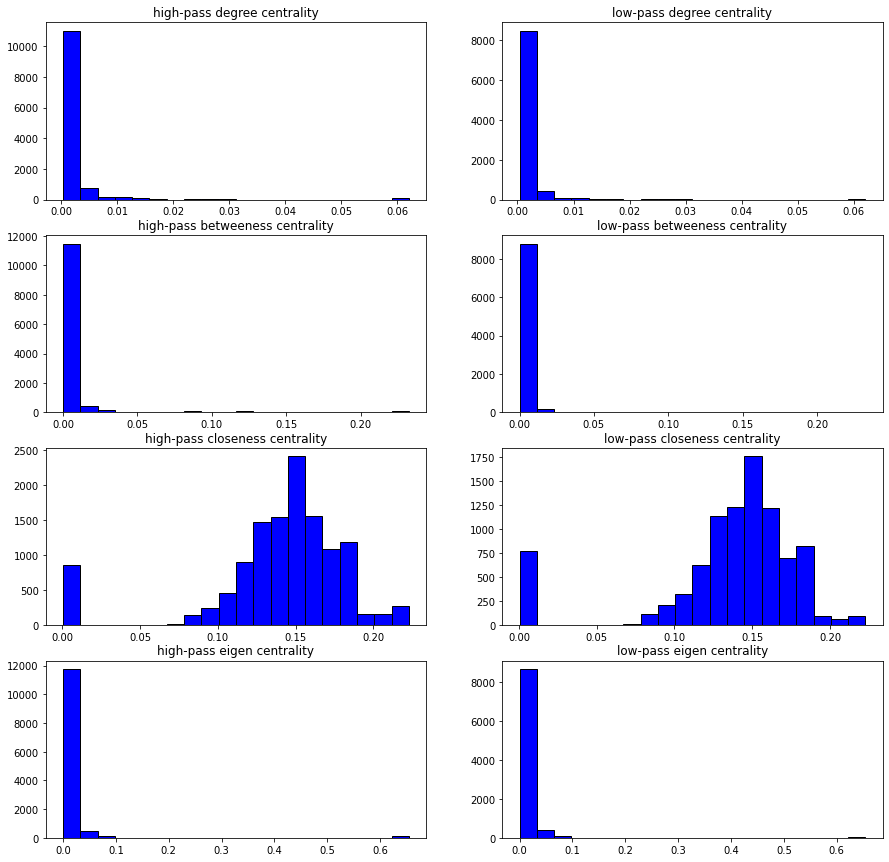

In [25]:
min_att = 1
plt.figure(figsize=(15,15))

print('Degree centrality')
ax1 = plt.subplot(4, 2, 1)
ax1.set_title('high-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(4, 2, 2)
ax2.set_title('low-pass degree centrality')
centralities = torch.tensor([centrality_degree[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nBetweeness centrality')
ax3 = plt.subplot(4, 2, 3)
ax3.set_title('high-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax4 = plt.subplot(4, 2, 4)
ax4.set_title('low-pass betweeness centrality')
centralities = torch.tensor([centrality_between[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nCloseness centrality')
ax5 = plt.subplot(4, 2, 5)
ax5.set_title('high-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

ax6 = plt.subplot(4, 2, 6)
ax6.set_title('low-pass closeness centrality')
centralities = torch.tensor([centrality_close[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)

print('\nEigen centrality')
ax7 = plt.subplot(4, 2, 7)
ax7.set_title('high-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20)


ax8 = plt.subplot(4, 2, 8)
ax8.set_title('low-pass eigen centrality')
centralities = torch.tensor([centrality_eigen[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass centrality mean: {}, std: {}'.format(centralities.mean().item(), centralities.std().item()))
plt.hist(centralities, color = 'blue', edgecolor = 'black', bins = 20);

Attended node page rank distribution by frequency bands

Page Rank
high-pass  page rank mean: 0.0006482384776967534, std: 0.0013473365029774375
low-pass page rank mean: 0.0005044004253825921, std: 0.000925248500112949


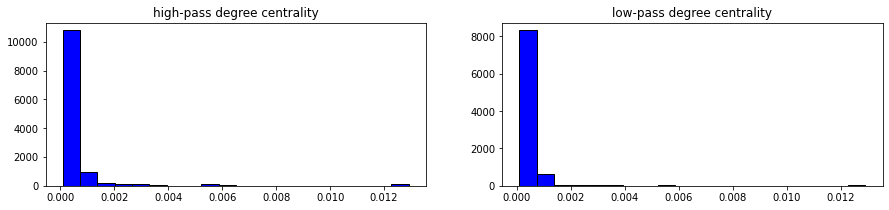

In [26]:
# compute all node's page rank
pr = nx.pagerank(G, alpha=0.9)

min_att = 1
plt.figure(figsize=(15,3))

print('Page Rank')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass degree centrality')
prs = torch.tensor([pr[n] for n in (high_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('high-pass  page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass degree centrality')
prs = torch.tensor([pr[n] for n in (low_attentions > min_att).nonzero(as_tuple=True)[1].tolist()])
print('low-pass page rank mean: {}, std: {}'.format(prs.mean().item(), prs.std().item()))
plt.hist(prs, color = 'blue', edgecolor = 'black', bins = 20);

Distance distribution of attended node

Attended node distance
high-pass node distance mean: 1.1910828351974487, std: 0.867484986782074
low-pass node distance mean: 0.5135242938995361, std: 0.5950663089752197


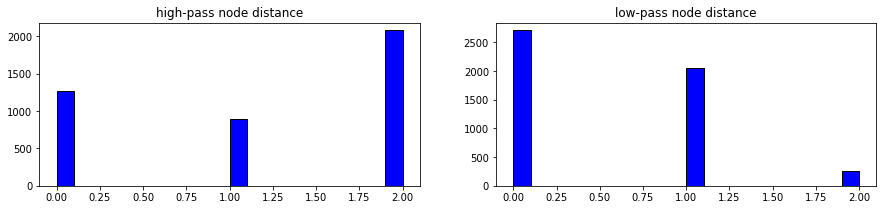

In [27]:
# Compute distances to from a node to its attended nodes
min_att = 2

high_distances = []

masked_high_attenions = high_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_high_attenions[n1, n2]:
            high_distances.append(nx.shortest_path_length(G, n1, n2))

low_distances = []

masked_low_attenions = low_attentions > min_att
for n1 in G.nodes:
    for n2 in G.nodes:
        if masked_low_attenions[n1, n2]:
            low_distances.append(nx.shortest_path_length(G, n1, n2))

            
plt.figure(figsize=(15,3))

print('Attended node distance')
ax1 = plt.subplot(1, 2, 1)
ax1.set_title('high-pass node distance')
distances = torch.tensor(high_distances).float()
print('high-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('low-pass node distance')
distances = torch.tensor(low_distances).float()
print('low-pass node distance mean: {}, std: {}'.format(distances.mean().item(), distances.std().item()))
plt.hist(distances, color = 'blue', edgecolor = 'black', bins = 20);

Re-train model with cutoff

In [56]:
# Similar result as cutoff after training
# from citation import run
#
# model_cutoff = Net(dataset)
#
# max_cutoff=1
# cutoff_kernel = model_cutoff.analysis.filter_kernel
# model_cutoff.analysis.filter_kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
# model_cutoff.analysis.filter._kernel = CutOff(max_val=max_cutoff, kernel=cutoff_kernel)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))
#
# run(dataset, model_cutoff, runs, epochs, lr, weight_decay, patience, None)
#
# plot_filter_banks(kernel=model_cutoff.analysis.filter_kernel)
# print(evaluate(model_cutoff, dataset[0]))


## Evaluate filterbanks

Define kernel to eliminate certain filterbanks

In [28]:
class Elimination(nn.Module):
    def __init__(self, zero_out_indices):
        super(Elimination, self).__init__()
        self.zero_out_indices = zero_out_indices

    def reset_parameters(self):
        pass

    def forward(self, x):
        x = filter_kernel(x)
        x[:, self.zero_out_indices] = torch.zeros(x.shape[0], len(self.zero_out_indices))
        return x

Evaluate each filter bank

In [29]:
all_indices = set(list(range(heads)))
for i in range(heads):
    zero_out_filters = list(all_indices.difference({i}))
    model.analysis.filter_kernel = Elimination(zero_out_filters)
    model.analysis.filter._kernel = Elimination(zero_out_filters)
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    print(evaluate(model, dataset[0]))

{'train_loss': 0.3834483027458191, 'train_acc': 0.8915562913907285, 'val_loss': 0.5163077712059021, 'val_acc': 0.852, 'test_loss': 0.5128327012062073, 'test_acc': 0.85, 'f1_score': 0.8689069423929099}
{'train_loss': 0.40817323327064514, 'train_acc': 0.8874172185430463, 'val_loss': 0.5296162366867065, 'val_acc': 0.846, 'test_loss': 0.5270540714263916, 'test_acc': 0.844, 'f1_score': 0.8637370753323486}
{'train_loss': 0.40817323327064514, 'train_acc': 0.8874172185430463, 'val_loss': 0.5296162366867065, 'val_acc': 0.846, 'test_loss': 0.5270540714263916, 'test_acc': 0.844, 'f1_score': 0.8637370753323486}
{'train_loss': 0.39907845854759216, 'train_acc': 0.8899006622516556, 'val_loss': 0.5215407013893127, 'val_acc': 0.85, 'test_loss': 0.5207884907722473, 'test_acc': 0.841, 'f1_score': 0.8644756277695717}
{'train_loss': 0.39918532967567444, 'train_acc': 0.8899006622516556, 'val_loss': 0.5216984152793884, 'val_acc': 0.848, 'test_loss': 0.520785927772522, 'test_acc': 0.841, 'f1_score': 0.8641063

Evaluate by eliminating only one filter bank

In [30]:
for i in range(heads):
    model.analysis.filter_kernel = Elimination([i])
    model.analysis.filter._kernel = Elimination([i])
    # plot_filter_banks(kernel=model.analysis.filter_kernel)
    print(evaluate(model, dataset[0]))


{'train_loss': 0.2931200861930847, 'train_acc': 0.9304635761589404, 'val_loss': 0.47086381912231445, 'val_acc': 0.858, 'test_loss': 0.4682612121105194, 'test_acc': 0.865, 'f1_score': 0.8929098966026587}
{'train_loss': 0.2787048816680908, 'train_acc': 0.9337748344370861, 'val_loss': 0.46922436356544495, 'val_acc': 0.864, 'test_loss': 0.4648117125034332, 'test_acc': 0.863, 'f1_score': 0.8947562776957164}
{'train_loss': 0.2787048816680908, 'train_acc': 0.9337748344370861, 'val_loss': 0.46922436356544495, 'val_acc': 0.864, 'test_loss': 0.4648117125034332, 'test_acc': 0.863, 'f1_score': 0.8947562776957164}
{'train_loss': 0.28306061029434204, 'train_acc': 0.9329470198675497, 'val_loss': 0.4720759093761444, 'val_acc': 0.86, 'test_loss': 0.46643394231796265, 'test_acc': 0.864, 'f1_score': 0.8940177252584932}
{'train_loss': 0.283002108335495, 'train_acc': 0.9329470198675497, 'val_loss': 0.47203123569488525, 'val_acc': 0.86, 'test_loss': 0.46643245220184326, 'test_acc': 0.864, 'f1_score': 0.8940

Load GAT model

In [31]:
from torch_geometric.nn import GATConv
class GAT(torch.nn.Module):
    def __init__(self, dataset):
        super(GAT, self).__init__()
        self.conv1 = GATConv(
            dataset.num_features,
            8,
            heads=8,
            dropout=0.6)
        self.conv2 = GATConv(
            64,
            dataset.num_classes,
            heads=1,
            concat=False,
            dropout=0.6)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_1, att_val_1) = self.conv1(x, edge_index, return_attention_weights=True)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x, (edge_index_2, att_val_2) = self.conv2(x, edge_index, return_attention_weights=True)
        att1 = torch.zeros(data.num_nodes, data.num_nodes, 8)
        att2 = torch.zeros(data.num_nodes, data.num_nodes)
        att1[list(map(lambda x: torch.tensor(x), edge_index_1.tolist()))] = att_val_1
        att2[list(map(lambda x: torch.tensor(x), edge_index_2.tolist()))] = att_val_2.view(-1)
        return F.log_softmax(x, dim=1), att1, att2

gat = GAT(dataset)
gat.load_state_dict(torch.load('./model/best_{}_gat.pkl'.format(dataset_name)))
gat_correct_indices = get_correctly_predicted_node_idx(gat, 'test')

with torch.no_grad():
    _, gat_att1, gat_att2 = gat(dataset[0])
evaluate(gat, dataset[0])

{'train_loss': 0.5066099166870117,
 'train_acc': 0.9213576158940397,
 'val_loss': 0.6066293120384216,
 'val_acc': 0.874,
 'test_loss': 0.6136246919631958,
 'test_acc': 0.88,
 'f1_score': 0.8973412112259971}

Comparison with GAT

In [32]:
model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices)]
gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices)]
model_not_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.difference(gat_correct_indices))]
model_and_gat_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(model_correct_indices.intersection(gat_correct_indices))]
gat_not_model_correct_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(gat_correct_indices.difference(model_correct_indices))]
gat_and_model_incorrect_nodes = dataset[0]['test_mask'].nonzero().view(-1)[list(set(dataset[0].y[dataset[0]['test_mask']].nonzero().view(-1).tolist()).difference(model_correct_indices).difference(gat_correct_indices))]
print('Number of node classified correctly by our model:', len(model_correct_nodes))
print('Number of node classified correctly by GAT:', len(gat_correct_nodes))
print('Number of node classified correctly by our model but not by GAT:', len(model_not_gat_correct_nodes))
print('Number of node classified correctly by both GAT and our model:', len(model_and_gat_correct_nodes))
print('Number of node classified correctly by GAT but not by our model:', len(gat_not_model_correct_nodes))
print('Number of node classified incorrectly by GAT and our model:', len(gat_and_model_incorrect_nodes))


Number of node classified correctly by our model: 863
Number of node classified correctly by GAT: 880
Number of node classified correctly by our model but not by GAT: 15
Number of node classified correctly by both GAT and our model: 848
Number of node classified correctly by GAT but not by our model: 32
Number of node classified incorrectly by GAT and our model: 89


In [33]:
gat_att1_sum = gat_att1.sum(dim=2)
model_att1_sum = torch.stack(att1).sum(dim=0)

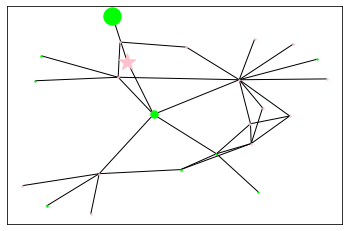

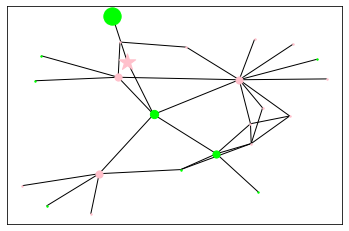

In [62]:
node = model_not_gat_correct_nodes[8].item()
Gego = nx.ego_graph(G, node, 3)
nodePos = nx.layout.spring_layout(Gego)
plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else torch.exp(gat_att1_sum[node, n]*3).clamp(max=300, min=2))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)


plt.figure()
for n in Gego.nodes:
    nx.draw_networkx_nodes(Gego, nodePos,
                           nodelist=[n],
                           node_color=node_colors[dataset[0].y[n].item()],
                           node_shape="*" if n == node else "o",
                           node_size=300 if n == node else torch.exp(model_att1_sum[node, n]*3).clamp(max=300, min=2))
nx.draw_networkx_edges(Gego,nodePos, linewidths=0.5)



Label distribution of nodes classified correctly by our model

matching labels in 1st hop: tensor(0.9169)
matching labels in 2st hop: tensor(0.8396)
matching labels in 3rd hop: tensor(0.7208)


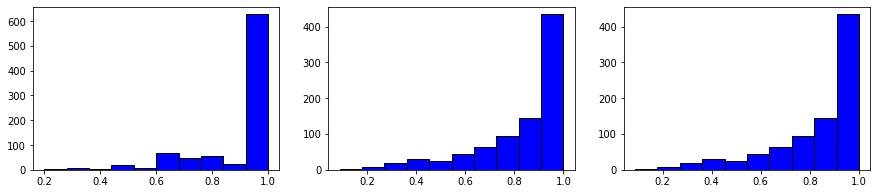

In [63]:
matching_labels_distribution(model_correct_nodes)

Label distribution of nodes classified correctly by GAT

matching labels in 1st hop: tensor(0.9118)
matching labels in 2st hop: tensor(0.8276)
matching labels in 3rd hop: tensor(0.7112)


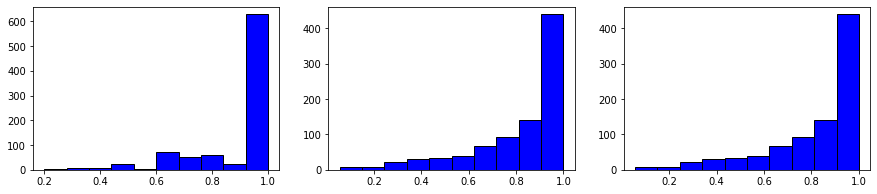

In [64]:
matching_labels_distribution(gat_correct_nodes)

Label distribution of nodes classified correctly by our model but not by GAT

matching labels in 1st hop: tensor(0.7181)
matching labels in 2st hop: tensor(0.6353)
matching labels in 3rd hop: tensor(0.5350)


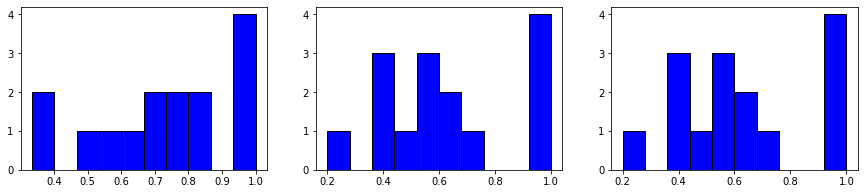

In [68]:
matching_labels_distribution(model_not_gat_correct_nodes)

Label distribution of nodes classified correctly our model and by GAT

matching labels in 1st hop: tensor(0.9204)
matching labels in 2st hop: tensor(0.8432)
matching labels in 3rd hop: tensor(0.7241)


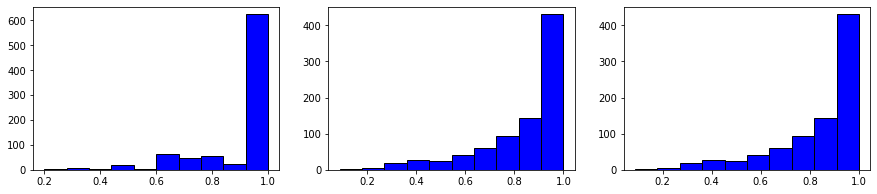

In [66]:
matching_labels_distribution(model_and_gat_correct_nodes)

Label distribution of nodes classified correctly GAT but not by our model

matching labels in 1st hop: tensor(0.6824)
matching labels in 2st hop: tensor(0.4137)
matching labels in 3rd hop: tensor(0.3694)


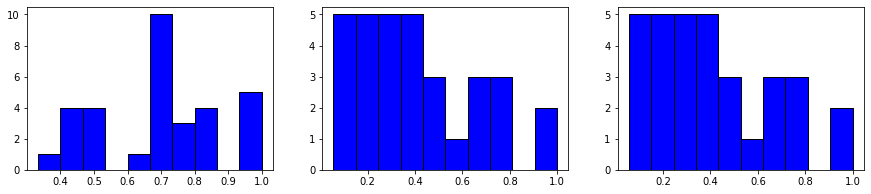

In [67]:
matching_labels_distribution(gat_not_model_correct_nodes)

Label distribution of nodes classified incorrectly by both GAT and our model

matching labels in 1st hop: tensor(0.5157)
matching labels in 2st hop: tensor(0.3686)
matching labels in 3rd hop: tensor(0.3230)


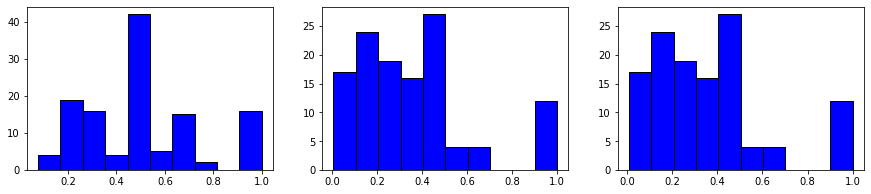

In [34]:
matching_labels_distribution(gat_and_model_incorrect_nodes)